# Interacting with Articulated Agents

In this tutorial we will show how to interact in Habitat via articulated agents. These are agents composed of different parts which can be articulated. Examples of these agents include different commercial robots (such as Spot, Fetch, Franka) or humanoids.
In this tutorial we will explore how to interact in Habitat with such agents. We will cover the following topics:

- How to initialize an agent
- Moving an agent around the scene
- Dynamic vs Kinematic Simulation
- Interacting with objects
- Interacting with Actions
- Multi-Agent simulation


In [1]:

import habitat_sim
import magnum as mn
import warnings
from habitat.tasks.rearrange.rearrange_sim import RearrangeSim
warnings.filterwarnings('ignore')
from habitat_sim.utils.settings import make_cfg
from matplotlib import pyplot as plt
from habitat_sim.utils import viz_utils as vut
from omegaconf import DictConfig
import numpy as np
from habitat.articulated_agents.robots import FetchRobot
from habitat.config.default import get_agent_config
from habitat.config.default_structured_configs import ThirdRGBSensorConfig, HeadRGBSensorConfig, HeadPanopticSensorConfig
from habitat.config.default_structured_configs import SimulatorConfig, HabitatSimV0Config, AgentConfig
from habitat.config.default import get_agent_config
import habitat
from habitat_sim.physics import JointMotorSettings, MotionType
from omegaconf import OmegaConf

import git, os
repo = git.Repo(".", search_parent_directories=True)
dir_path = repo.working_tree_dir
data_path = os.path.join(dir_path, "data")
# os.chdir(dir_path)

%matplotlib widget

pybullet build time: Feb 16 2024 15:08:58


In [2]:
import os

# To use data in repo root
os.chdir("/home/junting/repo/habitat-lab")

In [3]:
# Download necessary data. This step may take a while but will only be executed once.
# ! ln -s ../../data .
# We will download spot to show interaction between the spot robot and fetch
# ! python -m habitat_sim.utils.datasets_download --no-replace --uids hab_spot_arm hab3_bench_assets ycb


# Initializing a scene with agents
The first thing we want to do is to initialize the simulator to include different agents. 

In the first part of this tutorial we will use `RearrangeSim` as our simulator, which is an abstraction over [HabitatSimulator](https://aihabitat.org/docs/habitat-lab/habitat.core.simulator.Simulator.html) and includes functionalities to update agent cameras and position or interact with objects. In the second part of the tutorial, we will be defining agent actions and will be using a `RearrangeEnvironment`, which contains a reference to the simulator, as well as functions to define and execute agent actions, obtain rewards or termination conditions. The RearrangeEnvironment will also be used to train agents via RL, as shown in the tutorial TODO:


## Defining agent configurations
We start by defining a configuration for each agent we want to add. Articulated agents are represented as any other articulated object, and are therefore defined via an URDF file. While this file is enough to represent the agent as an object, it doesn't include a way to easily set its base position, reset its joints, move a specific part or query other attributes.

To simplify this, we provide an abstraction, `ArticulatedAgent`, which will wrap habitat-sim's ManagedArticulatedObject class initialized from the URDF and provide functionalities that are commonly useful for agent control. You can view the different ArticulatedAgents (robots and humanoids) [here](https://github.com/facebookresearch/habitat-lab/tree/main/habitat-lab/habitat/articulated_agents).

In [4]:
# Define the agent configuration
main_agent_config = AgentConfig()
urdf_path = os.path.join(data_path, "robots/hab_fetch/robots/hab_fetch.urdf")
main_agent_config.articulated_agent_urdf = urdf_path
main_agent_config.articulated_agent_type = "FetchRobot"

# Define sensors that will be attached to this agent, here a third_rgb sensor and a head_rgb.
# We will later talk about why we are giving the sensors these names
main_agent_config.sim_sensors = {
    "third_rgb": ThirdRGBSensorConfig(),
    "head_rgb": HeadRGBSensorConfig(),
}

# We create a dictionary with names of agents and their corresponding agent configuration
agent_dict = {"main_agent": main_agent_config}


In [5]:
def make_sim_cfg(agent_dict):
    # Start the scene config
    sim_cfg = SimulatorConfig(type="RearrangeSim-v0")
    
    # This is for better graphics
    sim_cfg.habitat_sim_v0.enable_hbao = True
    sim_cfg.habitat_sim_v0.enable_physics = True

    
    # Set up an example scene
    sim_cfg.scene = os.path.join(data_path, "hab3_bench_assets/hab3-hssd/scenes/103997919_171031233.scene_instance.json")
    sim_cfg.scene_dataset = os.path.join(data_path, "hab3_bench_assets/hab3-hssd/hab3-hssd.scene_dataset_config.json")
    sim_cfg.additional_object_paths = [os.path.join(data_path, 'objects/ycb/configs/')]

    
    cfg = OmegaConf.create(sim_cfg)

    # Set the scene agents
    cfg.agents = agent_dict
    cfg.agents_order = list(cfg.agents.keys())
    return cfg


def init_rearrange_sim(agent_dict):
    # Start the scene config
    sim_cfg = make_sim_cfg(agent_dict)    
    cfg = OmegaConf.create(sim_cfg)
    
    # Create the scene
    sim = RearrangeSim(cfg)

    # This is needed to initialize the agents
    sim.agents_mgr.on_new_scene()

    # For this tutorial, we will also add an extra camera that will be used for third person recording.
    camera_sensor_spec = habitat_sim.CameraSensorSpec()
    camera_sensor_spec.sensor_type = habitat_sim.SensorType.COLOR
    camera_sensor_spec.uuid = "scene_camera_rgb"

    # TODO: this is a bit dirty but I think its nice as it shows how to modify a camera sensor...
    sim.add_sensor(camera_sensor_spec, 0)

    return sim


## Initializing the scene
We can now initialize the scene. As mentioned before, we will be using here `RearrangeSim` to easily be able to interact with objects.

We create a scene init function that will take as input a dictionary of agent configurations, as the one we defined before.

In [5]:
sim = init_rearrange_sim(agent_dict)

[22:57:26:744536]:[Error]:[Metadata] SceneDatasetAttributesManager.cpp(304)::validateMap : `semantic_scene_descriptor_instances` Value : `semantics/hssd-hab_semantic_lexicon.json` not found on disk as absolute path or relative to `/home/junting/repo/habitat-lab/data/hab3_bench_assets/hab3-hssd`
[22:57:26:830154]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'hab3-hssd' : Lighting Layout Attributes '/home/junting/repo/habitat-lab/data/hab3_bench_assets/hab3-hssd/scenes/103997919_171031233.scene_instance.json' specified in Scene Attributes but does not exist in dataset, so creating default.
[22:57:26:830390]:[Warning]:[Scene] SemanticScene.h(315)::checkFileExists : ::loadSemanticSceneDescriptor: Filesemantics/hssd-hab_semantic_lexicon.jsondoes not exist.  Aborting load.
[22:57:26:830401]:[Warning]:[Scene] SemanticScene.cpp(121)::loadSemanticSceneDescriptor : SSD File Naming Issue! Neither SemanticAttributes-provided name : `semantics/hssd-

Renderer: NVIDIA GeForce RTX 3080/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 525.147.05
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_texture_view
    GL_ARB_framebuffer_no_attachments
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
    GL_KHR_parallel_shader_compile
    GL_NV_depth_buffer_float
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


We just initialized our scene! We can now query and set our agent position

In [6]:
init_pos = mn.Vector3(-5.5,0,-1.5)
art_agent = sim.articulated_agent
# We will see later about this
art_agent.sim_obj.motion_type = MotionType.KINEMATIC
print("Current agent position:", art_agent.base_pos)
art_agent.base_pos = init_pos 
print("New agent position:", art_agent.base_pos)
# We take a step to update agent position
_ = sim.step({})

Current agent position: Vector(0, 0, 0)
New agent position: Vector(-5.5, 0, -1.5)


We can also take observations in the environment. Here we get three sensors, two of which we defined in the config and one which we added afterwards.

In [8]:
observations = sim.get_sensor_observations()
print(observations.keys())

dict_keys(['third_rgb', 'head_rgb', 'scene_camera_rgb'])


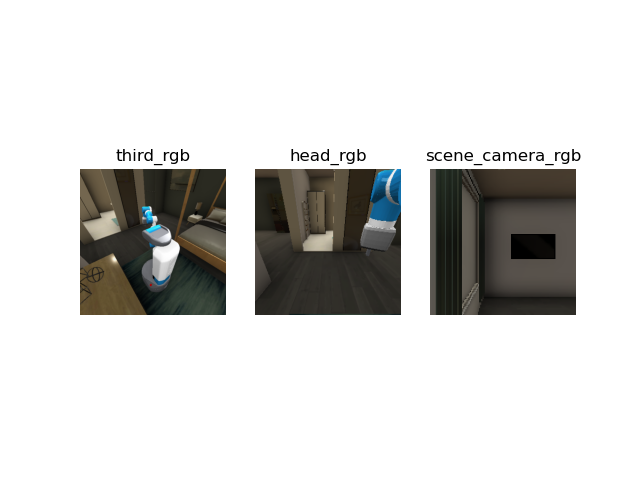

In [9]:
_, ax = plt.subplots(1,len(observations.keys()))

for ind, name in enumerate(observations.keys()):
    ax[ind].imshow(observations[name])
    ax[ind].set_axis_off()
    ax[ind].set_title(name)

The first two sensors shown here are special. They are attached to a particular part of the agent, and will be updated as we update the agent. The third one is not attached to the agent.
The reason for this is that the first two sensors start with `third` and `head`, which are special camera parameters which will have a particular behavior for this robot. You can see the camera parameters here:

In [10]:
art_agent.params.cameras.keys()

dict_keys(['articulated_agent_arm', 'head', 'third'])

Whenever a sensor name starts with any of these names, it will be set to have the behavior specified in the agent_params. You can look at the ArticulatedAgent definition to see the different specified cameras.

# Moving an agent around the scene
The next step is to move the agent and its parts around the scene. Let's start by translating and rotating the agent base. We will be recording each frame and generating a video.

## Moving the agent base

In [11]:
observations = []
num_iter = 100
pos_delta = mn.Vector3(0.02,0,0)
rot_delta = np.pi / (8 * num_iter)
art_agent.base_pos = init_pos

sim.reset()
# set_fixed_camera(sim)
for _ in range(num_iter):
    # TODO: this actually seems to give issues...
    art_agent.base_pos = art_agent.base_pos + pos_delta
    art_agent.base_rot = art_agent.base_rot + rot_delta
    sim.step({})
    observations.append(sim.get_sensor_observations())

vut.make_video(
    observations,
    "scene_camera_rgb",
    "color",
    "robot_tutorial_video",
    open_vid=True,
)
vut.make_video(
    observations,
    "third_rgb",
    "color",
    "robot_tutorial_video",
    open_vid=True,
)

Encoding the video: robot_tutorial_video.mp4 
Encoding the video: robot_tutorial_video.mp4 


As we can see, the third_rgb camera was set to track the agent, whereas the scene_camera_rgb remained fixed.

## Updating agent articulations
Articulated Agent also includes reference attributes, that helps us easily access and modify relevant parameters of the robot, such as the arm joints, or get the end effector. We can look at the position of the end effector, or the arm joints:


In [12]:
sim.reset()

observations = []
# We start by setting the arm to the minimum value
lower_limit = art_agent.arm_joint_limits[0].copy()
lower_limit[lower_limit == -np.inf] = 0
upper_limit = art_agent.arm_joint_limits[1].copy()
upper_limit[upper_limit == np.inf] = 0
for i in range(num_iter):
    alpha = i/num_iter
    current_joints = upper_limit * alpha + lower_limit * (1 - alpha)
    art_agent.arm_joint_pos = current_joints
    sim.step({})
    observations.append(sim.get_sensor_observations())
    if i in [0, num_iter-1]:
        print(f"Step {i}:")
        print("Arm joint positions:", art_agent.arm_joint_pos)
        print("Arm end effector translation:", art_agent.ee_transform().translation)
        print(art_agent.sim_obj.joint_positions)

vut.make_video(
    observations,
    "third_rgb",
    "color",
    "robot_tutorial_video",
    open_vid=True,
)


Step 0:
Arm joint positions: [-1.6056 -1.221   0.     -2.251   0.     -2.16    0.    ]
Arm end effector translation: Vector(-3.40404, 0.979, -1.34756)
[0.0, 0.0, 0.15000000596046448, 0.0, 1.4500000476837158, -1.6055999994277954, -1.2209999561309814, 0.0, -2.250999927520752, 0.0, -2.1600000858306885, 0.0, 0.0, 0.0]
Step 99:
Arm joint positions: [1.5734881 1.49061   0.        2.2059798 0.        2.1168    0.       ]
Arm end effector translation: Vector(-3.51502, 0.886575, -1.63032)
[0.0, 0.0, 0.15000000596046448, 0.0, 1.4500000476837158, 1.5734881162643433, 1.4906100034713745, 0.0, 2.205979824066162, 0.0, 2.11680006980896, 0.0, 0.0, 0.0]
Encoding the video: robot_tutorial_video.mp4 


# Dynamic vs Kinematic Simulation
So far, we've been updating the agent kinematically. We can also set the agent to be dynamic, such that physical forces modify the state of the agent

In [13]:
# TODO: doesnt work. Gravity does not seem to be doing anything :/
# We will initialize the agent 0.3 meters away from the floor and let it fall
sim = init_rearrange_sim(agent_dict)
art_agent = sim.articulated_agent
art_agent._fixed_base = False
sim.agents_mgr.on_new_scene()

# The base is not fixed anymore
art_agent.sim_obj.motion_type = MotionType.DYNAMIC


art_agent.base_pos = init_pos + mn.Vector3(0,1.5,0)

_ = sim.step({})
observations = []
fps = 60 # Default value for make video
dt = 1./fps
for _ in range(120):    
    sim.step_physics(dt)
    observations.append(sim.get_sensor_observations())
    
 

vut.make_video(
    observations,
    "third_rgb",
    "color",
    "robot_tutorial_video",
    open_vid=True,
)


[20:41:57:650762]:[Error]:[Metadata] SceneDatasetAttributesManager.cpp(304)::validateMap : `semantic_scene_descriptor_instances` Value : `semantics/hssd-hab_semantic_lexicon.json` not found on disk as absolute path or relative to `/home/junting/repo/habitat-lab/data/hab3_bench_assets/hab3-hssd`
[20:41:57:655348]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'hab3-hssd' : Lighting Layout Attributes '/home/junting/repo/habitat-lab/data/hab3_bench_assets/hab3-hssd/scenes/103997919_171031233.scene_instance.json' specified in Scene Attributes but does not exist in dataset, so creating default.
[20:41:57:655626]:[Warning]:[Scene] SemanticScene.h(315)::checkFileExists : ::loadSemanticSceneDescriptor: Filesemantics/hssd-hab_semantic_lexicon.jsondoes not exist.  Aborting load.
[20:41:57:655646]:[Warning]:[Scene] SemanticScene.cpp(121)::loadSemanticSceneDescriptor : SSD File Naming Issue! Neither SemanticAttributes-provided name : `semantics/hssd-

Encoding the video: robot_tutorial_video.mp4 


# Interacting with objects
We will now look at how to interact with objects in the scene. For this, we will start by loading an episode from a pregenerated dataset, which contains a scene with pre-initialized objects.

In [14]:
from habitat.datasets.rearrange.rearrange_dataset import RearrangeEpisode
import gzip
import json

# Define the agent configuration
episode_file = os.path.join(data_path, "hab3_bench_assets/episode_datasets/small_large.json.gz")
sim = init_rearrange_sim(agent_dict)
# Load the dataset
with gzip.open(episode_file, "rt") as f: 
    episode_files = json.loads(f.read())

# Get the first episode
episode = episode_files["episodes"][0]
rearrange_episode = RearrangeEpisode(**episode)

art_agent = sim.articulated_agent
art_agent._fixed_base = True
sim.agents_mgr.on_new_scene()


sim.reconfigure(sim.habitat_config, ep_info=rearrange_episode)
sim.reset()

art_agent.sim_obj.motion_type = MotionType.KINEMATIC
sim.articulated_agent.base_pos =  init_pos 
_ = sim.step({})


[20:41:59:368725]:[Error]:[Metadata] SceneDatasetAttributesManager.cpp(304)::validateMap : `semantic_scene_descriptor_instances` Value : `semantics/hssd-hab_semantic_lexicon.json` not found on disk as absolute path or relative to `/home/junting/repo/habitat-lab/data/hab3_bench_assets/hab3-hssd`
[20:41:59:371695]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'hab3-hssd' : Lighting Layout Attributes '/home/junting/repo/habitat-lab/data/hab3_bench_assets/hab3-hssd/scenes/103997919_171031233.scene_instance.json' specified in Scene Attributes but does not exist in dataset, so creating default.
[20:41:59:371902]:[Warning]:[Scene] SemanticScene.h(315)::checkFileExists : ::loadSemanticSceneDescriptor: Filesemantics/hssd-hab_semantic_lexicon.jsondoes not exist.  Aborting load.
[20:41:59:371914]:[Warning]:[Scene] SemanticScene.cpp(121)::loadSemanticSceneDescriptor : SSD File Naming Issue! Neither SemanticAttributes-provided name : `semantics/hssd-

The first thing we will do is to look at the objects currently instanced in the scene. The simulator provides a RigidObjectManager and an ArticulatedObjectManger for accessing, adding, and removing objects in the scene:

In [15]:
aom = sim.get_articulated_object_manager()
rom = sim.get_rigid_object_manager()

# We can query the articulated and rigid objects

print("List of articulated objects:")
for handle, ao in aom.get_objects_by_handle_substring().items():
    print(handle, "id", aom.get_object_id_by_handle(handle))

print("\nList of rigid objects:")
obj_ids = []
for handle, ro in rom.get_objects_by_handle_substring().items():
    if ro.awake:
        print(handle, "id", ro.object_id)
        obj_ids.append(ro.object_id)

List of articulated objects:
hab_fetch_:0000 id 82

List of rigid objects:
002_master_chef_can_:0000 id 108
002_master_chef_can_:0001 id 109
002_master_chef_can_:0002 id 110
002_master_chef_can_:0004 id 112
002_master_chef_can_:0003 id 111
004_sugar_box_:0000 id 113
007_tuna_fish_can_:0000 id 114
009_gelatin_box_:0000 id 115
010_potted_meat_can_:0000 id 116
024_bowl_:0000 id 117


Above we listed all object instances in the scene. We can also retrieve the episode's RigidObjects using RearrangeSim's `scene_obj_ids` cache.

Let's set the agent to interact with the object. We will first teleport the agent somewhere close to the object, and then grab the object. To teleport the agent
we will first look at the object coordinate, and sample a navigable area next to the object coordinate.

In [16]:
sim.reset()
art_agent.sim_obj.motion_type = MotionType.KINEMATIC
obj_id = sim.scene_obj_ids[0]
first_object = rom.get_object_by_id(obj_id)

object_trans = first_object.translation
print(first_object.handle, "is in", object_trans)

sample = sim.pathfinder.get_random_navigable_point_near(
    circle_center=object_trans, radius=1.0, island_index=-1
)
vec_sample_obj = object_trans - sample

angle_sample_obj = np.arctan2(-vec_sample_obj[2], vec_sample_obj[0])

sim.articulated_agent.base_pos = sample
sim.articulated_agent.base_rot = angle_sample_obj
obs = sim.step({})

plt.imshow(obs["head_rgb"])

002_master_chef_can_:0000 is in Vector(-7.16471, 0.990517, -5.21936)


We will now pick the object. In this example, we will directly attach the object to the robot arm, without animating the arm in any way. We also provide a way to train policies so that the arm approaches the object. For more details see the tutorial TODO

In [17]:
# We use a grasp manager to interact with the object:
agent_id = 0
grasp_manager = sim.agents_mgr[agent_id].grasp_mgrs[0]
grasp_manager.snap_to_obj(obj_id)
obs = sim.step({})
plt.imshow(obs["head_rgb"])

We can move around and drop the object

In [18]:
num_iter = 100
observations = []

sim.articulated_agent.base_pos = sample
for _ in range(num_iter):    
    forward_vec = art_agent.base_transformation.transform_vector(mn.Vector3(1,0,0))
    art_agent.base_pos = art_agent.base_pos + forward_vec * 0.02
    observations.append(sim.step({}))
    
# Remove the object
grasp_manager.desnap()
for _ in range(20):
    observations.append(sim.step({}))
vut.make_video(
    observations,
    "head_rgb",
    "color",
    "robot_tutorial_video",
    open_vid=True,
)


Encoding the video: robot_tutorial_video.mp4 


# Defining agent actions
So far, we have been controlling agents by directly updating the robot parameters. In  many cases, you may want to abstract interaction into actions that update the robot. These actions can then be called by a planner or a learned policy. In this section we will show how to define and control agents with these actions. The Habitat Quickstart provides more instructions into how to add actions https://aihabitat.org/docs/habitat-lab/quickstart.html.
For more details into training policies, you can look at the tutorial. TODO.

To execute actions, we will be using the `Env`, which is an object that contains a simulator instance as well as a set of action definitions and specifiable rewards. We will not be going through the specifiable rewards. 

## Defining an environment
We will start by defining the environment class. A key difference is that now we also define actions that the environment will have

In [6]:

from habitat.config.default_structured_configs import TaskConfig, EnvironmentConfig, DatasetConfig, HabitatConfig
from habitat.config.default_structured_configs import ArmActionConfig, BaseVelocityActionConfig, OracleNavActionConfig, ActionConfig
from habitat.core.env import Env
def make_sim_cfg(agent_dict):
    # Start the scene config
    sim_cfg = SimulatorConfig(type="RearrangeSim-v0")
    
    # Enable Horizon Based Ambient Occlusion (HBAO) to approximate shadows.
    sim_cfg.habitat_sim_v0.enable_hbao = True
    
    sim_cfg.habitat_sim_v0.enable_physics = True

    
    # Set up an example scene
    sim_cfg.scene = os.path.join(data_path, "hab3_bench_assets/hab3-hssd/scenes/103997919_171031233.scene_instance.json")
    sim_cfg.scene_dataset = os.path.join(data_path, "hab3_bench_assets/hab3-hssd/hab3-hssd.scene_dataset_config.json")
    sim_cfg.additional_object_paths = [os.path.join(data_path, 'objects/ycb/configs/')]

    
    cfg = OmegaConf.create(sim_cfg)

    # Set the scene agents
    cfg.agents = agent_dict
    cfg.agents_order = list(cfg.agents.keys())
    return cfg

def make_hab_cfg(agent_dict, action_dict):
    sim_cfg = make_sim_cfg(agent_dict)
    task_cfg = TaskConfig(type="RearrangeEmptyTask-v0")
    task_cfg.actions = action_dict
    env_cfg = EnvironmentConfig()
    dataset_cfg = DatasetConfig(type="RearrangeDataset-v0", data_path="data/hab3_bench_assets/episode_datasets/small_large.json.gz")
    
    
    hab_cfg = HabitatConfig()
    hab_cfg.environment = env_cfg
    hab_cfg.task = task_cfg
    hab_cfg.dataset = dataset_cfg
    hab_cfg.simulator = sim_cfg
    hab_cfg.simulator.seed = hab_cfg.seed

    return hab_cfg

def init_rearrange_env(agent_dict, action_dict):
    hab_cfg = make_hab_cfg(agent_dict, action_dict)
    res_cfg = OmegaConf.create(hab_cfg)
    return Env(res_cfg)

In [7]:
action_dict = {
    "oracle_magic_grasp_action": ArmActionConfig(type="MagicGraspAction"),
    "base_velocity_action": BaseVelocityActionConfig(),
    "oracle_coord_action": OracleNavActionConfig(type="OracleNavCoordinateAction", spawn_max_dist_to_obj=1.0, motion_control="base_velocity_non_cylinder")
}
env = init_rearrange_env(agent_dict, action_dict)


2024-02-21 13:39:54,465 Initializing dataset RearrangeDataset-v0
2024-02-21 13:39:54,468 initializing sim RearrangeSim-v0


[13:39:54:584603]:[Error]:[Metadata] SceneDatasetAttributesManager.cpp(304)::validateMap : `semantic_scene_descriptor_instances` Value : `semantics/hssd-hab_semantic_lexicon.json` not found on disk as absolute path or relative to `data/hab3_bench_assets/hab3-hssd`
[13:39:54:661723]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'hab3-hssd' : Lighting Layout Attributes 'data/hab3_bench_assets/hab3-hssd/scenes/103997919_171031233.scene_instance.json' specified in Scene Attributes but does not exist in dataset, so creating default.
[13:39:54:661981]:[Warning]:[Scene] SemanticScene.h(315)::checkFileExists : ::loadSemanticSceneDescriptor: Filesemantics/hssd-hab_semantic_lexicon.jsondoes not exist.  Aborting load.
[13:39:54:661991]:[Warning]:[Scene] SemanticScene.cpp(121)::loadSemanticSceneDescriptor : SSD File Naming Issue! Neither SemanticAttributes-provided name : `semantics/hssd-hab_semantic_lexicon.json` nor constructed filename : `semanti

Renderer: NVIDIA GeForce RTX 3080/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 525.147.05
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_texture_view
    GL_ARB_framebuffer_no_attachments
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
    GL_KHR_parallel_shader_compile
    GL_NV_depth_buffer_float
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


In [ ]:
# The environment contains a pointer to an habitat simulator, which allows us to reproduce the steps we did before
print(env._sim)

NameError: name 'env' is not defined

In [ ]:

# We can query the actions available, and their action space:
for action_name, action_space in env.action_space.items():
    print(action_name, action_space)

NameError: name 'env' is not defined

In [ ]:
# Let's get an observation as before:
env.reset()
obs = env.step({"action": (), "action_args": {}})
plt.imshow(obs["third_rgb"])

We can now call actions in the environment to update the agent. For this, we call the step function with the name of the action we want to execute and the parameters. We can also execute multiple actions at the same time. You can also implement novel actions, see the tutorial: TODO

In [24]:
# We can now call the defined actions
observations = []
num_iter = 40
for _ in range(num_iter):
    params = env.action_space["base_velocity_action"].sample()
    action_dict = {
        "action": "base_velocity_action",
        "action_args": params
    }
    observations.append(env.step(action_dict))
vut.make_video(
    observations,
    "third_rgb",
    "color",
    "robot_tutorial_video",
    open_vid=True,
)

NameError: name 'env' is not defined

One of the actions we defined was the OracleNavCoordAction, which uses a path planner to navigate to a given coordinate. We can use it to navigate to a specific object instance.

In [ ]:
env.reset()
rom = env.sim.get_rigid_object_manager()
# env.sim.articulated_agent.base_pos = init_pos
# As before, we get a navigation point next to an object id

obj_id = env.sim.scene_obj_ids[0]
first_object = rom.get_object_by_id(obj_id)

object_trans = first_object.translation
print(first_object.handle, "is in", object_trans)
# TODO: unoccluded object did not work
# print(sample)
observations = []
delta = 2.0

object_agent_vec = env.sim.articulated_agent.base_pos - object_trans
object_agent_vec.y = 0
dist_agent_object = object_agent_vec.length()
# Walk towards the object

agent_displ = np.inf
agent_rot = np.inf
prev_rot = env.sim.articulated_agent.base_rot
prev_pos = env.sim.articulated_agent.base_pos
while agent_displ > 1e-9 or agent_rot > 1e-9:
    prev_rot = env.sim.articulated_agent.base_rot
    prev_pos = env.sim.articulated_agent.base_pos
    action_dict = {
        "action": ("oracle_coord_action"), 
        "action_args": {
              "oracle_nav_lookat_action": object_trans,
              "mode": 1
          }
    }
    observations.append(env.step(action_dict))
    
    cur_rot = env.sim.articulated_agent.base_rot
    cur_pos = env.sim.articulated_agent.base_pos
    agent_displ = (cur_pos - prev_pos).length()
    agent_rot = np.abs(cur_rot - prev_rot)

# Wait
for _ in range(20):
    action_dict = {"action": (), "action_args": {}}
    observations.append(env.step(action_dict))    
vut.make_video(
    observations,
    "third_rgb",
    "color",
    "robot_tutorial_video",
    open_vid=True,
)

002_master_chef_can_:0000 is in Vector(-0.26411, 0.93693, -0.18816)


ValueError: Cannot access `sim.articulated_agent` with multiple articulated agents

## Defining new actions
In the previous example we used actions to do navigation. We would like to also be able to pick up objects given an id. However, Habitat doesn't have a pre-defined action for that. We will look at a picking action here. You can find more information on adding actions in TODO:

In [ ]:
from habitat.tasks.rearrange.actions.articulated_agent_action import ArticulatedAgentAction
from habitat.core.registry import registry
from gym import spaces


@registry.register_task_action
class PickObjIdAction(ArticulatedAgentAction):
    
    @property
    def action_space(self):
        MAX_OBJ_ID = 1000
        return spaces.Dict({
            f"{self._action_arg_prefix}pick_obj_id": spaces.Discrete(MAX_OBJ_ID)
        })

    def step(self, *args, **kwargs):
        obj_id = kwargs[f"{self._action_arg_prefix}pick_obj_id"]
        print(self.cur_grasp_mgr, obj_id)
        self.cur_grasp_mgr.snap_to_obj(obj_id)

action_dict = {
    "pick_obj_id_action": ActionConfig(type="PickObjIdAction"),
    "base_velocity_action": BaseVelocityActionConfig(),
    "oracle_coord_action": OracleNavActionConfig(type="OracleNavCoordinateAction", spawn_max_dist_to_obj=1.0)
}
env = init_rearrange_env(agent_dict, action_dict)

2024-02-20 15:42:07,309 Initializing dataset RearrangeDataset-v0
2024-02-20 15:42:07,311 initializing sim RearrangeSim-v0
[15:42:07:440908]:[Error]:[Metadata] SceneDatasetAttributesManager.cpp(304)::validateMap : `semantic_scene_descriptor_instances` Value : `semantics/hssd-hab_semantic_lexicon.json` not found on disk as absolute path or relative to `data/hab3_bench_assets/hab3-hssd`
[15:42:07:444012]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'hab3-hssd' : Lighting Layout Attributes 'data/hab3_bench_assets/hab3-hssd/scenes/103997919_171031233.scene_instance.json' specified in Scene Attributes but does not exist in dataset, so creating default.
[15:42:07:444221]:[Warning]:[Scene] SemanticScene.h(315)::checkFileExists : ::loadSemanticSceneDescriptor: Filesemantics/hssd-hab_semantic_lexicon.jsondoes not exist.  Aborting load.
[15:42:07:444231]:[Warning]:[Scene] SemanticScene.cpp(121)::loadSemanticSceneDescriptor : SSD File Naming Issue!

AssertionError: Error in action: pick_obj_id_action. Multiagent actions should start with agent_X.

In [ ]:
env.reset()
rom = env.sim.get_rigid_object_manager()
# env.sim.articulated_agent.base_pos = init_pos
# As before, we get a navigation point next to an object id

obj_id = env.sim.scene_obj_ids[0]
first_object = rom.get_object_by_id(obj_id)

object_trans = first_object.translation
print(first_object.handle, "is in", object_trans)
# TODO: unoccluded object did not work
# print(sample)
observations = []
delta = 2.0

object_agent_vec = env.sim.articulated_agent.base_pos - object_trans
object_agent_vec.y = 0
dist_agent_object = object_agent_vec.length()
# Walk towards the object

agent_displ = np.inf
agent_rot = np.inf
prev_rot = env.sim.articulated_agent.base_rot
prev_pos = env.sim.articulated_agent.base_pos
while agent_displ > 1e-9 or agent_rot > 1e-9:
    prev_rot = env.sim.articulated_agent.base_rot
    prev_pos = env.sim.articulated_agent.base_pos
    action_dict = {
        "action": ("oracle_coord_action"), 
        "action_args": {
              "oracle_nav_lookat_action": object_trans,
              "mode": 1
          }
    }
    observations.append(env.step(action_dict))
    
    cur_rot = env.sim.articulated_agent.base_rot
    cur_pos = env.sim.articulated_agent.base_pos
    agent_displ = (cur_pos - prev_pos).length()
    agent_rot = np.abs(cur_rot - prev_rot)
    # print(agent_rot, agent_displ)

for _ in range(20):
    action_dict = {"action": (), "action_args": {}}
    observations.append(env.step(action_dict))    

action_dict = {"action": ("pick_obj_id_action"), "action_args": {"pick_obj_id": obj_id}}
observations.append(env.step(action_dict))
for _ in range(100):
    action_dict = {"action": (), "action_args": {}}
    observations.append(env.step(action_dict))    
vut.make_video(
    observations,
    "third_rgb",
    "color",
    "robot_tutorial_video",
    open_vid=True,
)

003_cracker_box_:0000 is in Vector(-5.55847, 0.95434, -2.40326)
<habitat.tasks.rearrange.rearrange_grasp_manager.RearrangeGraspManager object at 0x7f3c742f31c0> 108
Encoding the video: robot_tutorial_video.mp4 


# Multi-Agent Interaction
So far, we've been executing actions with a single agent. Habitat allows multi-agent execution, we will be looking here at how to do it 

In [ ]:
# We will download spot to show interaction between the spot robot and fetch
# ! python -m habitat_sim.utils.datasets_download --uids hab_spot_arm --no-replace

In [ ]:
ls data/robots/hab_spot_arm/urdf

hab_spot_arm.urdf*


In [8]:
# The main difference is in how we define the agent_dict.
# Important: When using more than one agent, we should call them agent_{idx} with idx being between 0 and
# the number of agents. This is required so that we can parse actions
import copy
# reload habitat.config module
# NOTE: leads to issubclass() type checking error
# from importlib import reload
# import habitat.config.default_structured_configs
# reload(habitat.config.default_structured_configs)
from habitat.config.default_structured_configs import (
    ArmActionConfig,
    BaseVelocityNonCylinderActionConfig,
    OracleNavActionConfig,
)

second_agent_config = copy.deepcopy(main_agent_config)
second_agent_config.articulated_agent_urdf = os.path.join(data_path, "robots/hab_spot_arm/urdf/hab_spot_arm.urdf")
second_agent_config.articulated_agent_type = "SpotRobot"


agent_dict = {"agent_0": main_agent_config, "agent_1": second_agent_config}
action_dict = {
    "oracle_magic_grasp_action": ArmActionConfig(type="MagicGraspAction"),
    # "base_velocity_action": BaseVelocityActionConfig(),
    "base_velocity_non_cylinder_action": BaseVelocityNonCylinderActionConfig(
        type="BaseVelNonCylinderAction"
    ),
    # "oracle_coord_action": OracleNavActionConfig(
    #     type="OracleNavCoordinateAction", spawn_max_dist_to_obj=1.0
    # ),
    "oracle_coord_action": OracleNavActionConfig(
        type="OracleNavCoordinateAction",
        spawn_max_dist_to_obj=1.0,
        motion_control="base_velocity_non_cylinder",
        navmesh_offset=[[0.0, 0.0], [0.25, 0.0], [-0.25, 0.0]],
    ),
}

multi_agent_action_dict = {}
for action_name, action_config in action_dict.items():
    for agent_id in range(2):
        multi_agent_action_dict[f"agent_{agent_id}_{action_name}"] = action_config 
env = init_rearrange_env(agent_dict, multi_agent_action_dict)

2024-02-21 13:40:07,560 Initializing dataset RearrangeDataset-v0
2024-02-21 13:40:07,563 initializing sim RearrangeSim-v0
[13:40:07:697550]:[Error]:[Metadata] SceneDatasetAttributesManager.cpp(304)::validateMap : `semantic_scene_descriptor_instances2024-02-21 13:40:07,951 Initializing task RearrangeEmptyTask-v0
` Value : `semantics/hssd-hab_semantic_lexicon.json` not found on disk as absolute path or relative to `data/hab3_bench_assets/hab3-hssd`
[13:40:07:700453]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'hab3-hssd' : Lighting Layout Attributes 'data/hab3_bench_assets/hab3-hssd/scenes/103997919_171031233.scene_instance.json' specified in Scene Attributes but does not exist in dataset, so creating default.
[13:40:07:700624]:[Warning]:[Scene] SemanticScene.h(315)::checkFileExists : ::loadSemanticSceneDescriptor: Filesemantics/hssd-hab_semantic_lexicon.jsondoes not exist.  Aborting load.
[13:40:07:700633]:[Warning]:[Scene] SemanticScen

#### The environment takes care about adding prefixes to observations, so that you can query the observation of each of the agents

[11:41:11:883620]:[Warning]:[Assets] ResourceManager.cpp(899)::createRenderAssetInstance : Instantiating render asset `/home/junting/repo/habitat-lab/data/robots/hab_spot_arm/urdf/../meshesColored/base.glb` with incompatible light setup, instance will not be correctly lit. For objects, please ensure 'requires lighting' is enabled in object config file.
[11:41:11:890778]:[Warning]:[Assets] ResourceManager.cpp(899)::createRenderAssetInstance : Instantiating render asset `/home/junting/repo/habitat-lab/data/robots/hab_spot_arm/urdf/../meshesColored/fl.hip.glb` with incompatible light setup, instance will not be correctly lit. For objects, please ensure 'requires lighting' is enabled in object config file.
[11:41:11:890824]:[Warning]:[Assets] ResourceManager.cpp(899)::createRenderAssetInstance : Instantiating render asset `/home/junting/repo/habitat-lab/data/robots/hab_spot_arm/urdf/../meshesColored/fl.uleg.glb` with incompatible light setup, instance will not be correctly lit. For objects

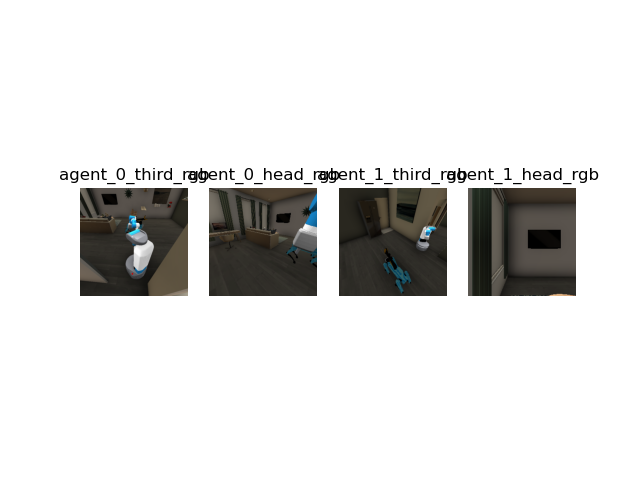

In [9]:
observations = env.reset()
# plt.figure(figsize=(20,10))
_, ax = plt.subplots(1,len(observations.keys()))

for ind, name in enumerate(observations.keys()):
    ax[ind].imshow(observations[name])
    ax[ind].set_axis_off()
    ax[ind].set_title(name)

In [9]:
# To query the agent positions, we need to use `agents_mgr[agent_index]` articulated_agent
env.sim.agents_mgr[1].articulated_agent

As before, we can call actions on the agents, prepending the agent_name before the action

In [10]:
env.reset()
rom = env.sim.get_rigid_object_manager()
# env.sim.articulated_agent.base_pos = init_pos
# As before, we get a navigation point next to an object id

obj_id = env.sim.scene_obj_ids[0]
first_object = rom.get_object_by_id(obj_id)

object_trans = first_object.translation
observations = []

# Walk towards the object

agent_displ = np.inf
agent_rot = np.inf
prev_rot = env.sim.agents_mgr[0].articulated_agent.base_rot
prev_pos = env.sim.agents_mgr[0].articulated_agent.base_pos
while agent_displ > 1e-9 or agent_rot > 1e-9:
    prev_rot = env.sim.agents_mgr[0].articulated_agent.base_rot
    prev_pos = env.sim.agents_mgr[0].articulated_agent.base_pos
    action_dict = {
        "action": ("agent_0_oracle_coord_action", "agent_1_oracle_coord_action"), 
        "action_args": {
              "agent_0_oracle_nav_lookat_action": object_trans,
              "agent_0_mode": 1,
              "agent_1_oracle_nav_lookat_action": object_trans,
              "agent_1_mode": 1
          }
    }
    observations.append(env.step(action_dict))
    
    cur_rot = env.sim.agents_mgr[0].articulated_agent.base_rot
    cur_pos = env.sim.agents_mgr[0].articulated_agent.base_pos
    agent_displ = (cur_pos - prev_pos).length()
    agent_rot = np.abs(cur_rot - prev_rot)
    # print(agent_rot, agent_displ)
vut.make_video(
    observations,
    "agent_1_third_rgb",
    "color",
    "robot_tutorial_video",
    open_vid=True,
)

[13:40:15:502744]:[Warning]:[Assets] ResourceManager.cpp(899)::createRenderAssetInstance : Instantiating render asset `/home/junting/repo/habitat-lab/data/robots/hab_spot_arm/urdf/../meshesColored/base.glb` with incompatible light setup, instance will not be correctly lit. For objects, please ensure 'requires lighting' is enabled in object config file.
[13:40:15:503056]:[Warning]:[Assets] ResourceManager.cpp(899)::createRenderAssetInstance : Instantiating render asset `/home/junting/repo/habitat-lab/data/robots/hab_spot_arm/urdf/../meshesColored/fl.hip.glb` with incompatible light setup, instance will not be correctly lit. For objects, please ensure 'requires lighting' is enabled in object config file.
[13:40:15:503075]:[Warning]:[Assets] ResourceManager.cpp(899)::createRenderAssetInstance : Instantiating render asset `/home/junting/repo/habitat-lab/data/robots/hab_spot_arm/urdf/../meshesColored/fl.uleg.glb` with incompatible light setup, instance will not be correctly lit. For objects

Encoding the video: robot_tutorial_video.mp4 
